Rossmann商店遍布7个国家，共3000个店铺，基于2.5年的历史日销售数据想要预测分布在德国各地的1115个店铺未来6周每日的销售量。
其中，销售量与很多因素有关（如促销、其他竞争商家、学校假期、州立节日、季节性、地理位置等）。
合理预测能够更加合理的安排员工时间，提高生产力和积极性。
预测结果的评价指标采用最小化均方根误差百分比RMSPE，其中$y_i$为真实值，$yhat_i$为预测值

min $RMSPE=\sqrt{\frac{1}{n}\sum_{i=0}^{n}(\frac{y_i-yhat_i}{y_i})^2}$

数据结构分析：

<font size=4>Files</font><br>
**train.csv** - historical data including Sales<br>
**test.csv** - historical data excluding Sales<br>
**sample_submission.csv** - a sample submission file in the correct format
store.csv - supplemental information about the stores<br>

<font size=4>Data fields</font><br>
Most of the fields are self-explanatory. The following are descriptions for those that aren't.<br>
**Id** - an Id that represents a (Store, Date) duple <font color=red>within the test set</font><br>
**Store** - a unique Id for each store<br>
**Sales** - the turnover for any given day (this is what you are predicting)<br>
**Customers** - the number of customers on a given day<br>
**Open** - an indicator for whether the store was open: 0 = closed, 1 = open<br>
**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None<br>
**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools<br>
**StoreType** - differentiates between 4 different store models: a, b, c, d<br>
**Assortment** - describes <font color=red>an assortment level</font>: a = basic, b = extra, c = extended<br>
**CompetitionDistance** - distance in meters to the nearest competitor store<br>
**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened<br>
**Promo** - indicates whether a store is running a promo on that day<br>
**<font color=red>Promo2</font>** is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating<br>
**<font color=red>Promo2Since[Year/Week]</font>** - describes the year and calendar week when the store started participating in Promo2<br>
**<font color=red>PromoInterval</font>** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

<font color=green>Gert Jacobusse（top1方案提出者）</font>使用超过20个XGBoost集成模型实现<br>   方案整理如下：

使用的预处理方法、监督学习方法及提升性能的tips：<br>
1 使用不同大小的时间窗平滑数据，e.g.上一季度，上半年，一年前，两年前..,这些平均能够分散开很多重要特征（一周的第几天、促销..）,便于观察<br>
2 一些时间指标也是很重要的，除了一年中的某个月，某一天，相对时间指标如自从暑假开始的天数等也很重要<br>
3 使用了xgboost<br>
4 使用hold-out set，预防过拟合，有时也会采用cross-validation(多个hold-out sets)<br>
5 如何构造hold-out set, 可以模仿train set和test set分割的方式，从train set中分割出hold-out set<br>
6 对于本赛题RossmannStore数据，模型中未包含最近月的数据几乎和包含最近月数据的模型表现一样好，意味着短期变化对预测影响较小<br>
7 50%时间用来特征工程，40%用来特征选择加模型集成，不到10%用于模型选择加调整

<font color=green>Anton Lebedevich（top10%方案提出者with R）</font>

http://mabrek.github.io/blog/kaggle-forecasting/
方案整理如下：

载入数据第一步就是将数据转化成多元常规时间序列，并运行SVD，发现以下结论：<br>
1 大部分商店并没有上升或下降的趋势<br>
2 存在季节变化，但在圣诞节时（节日）最明显<br>
3 大多数商店周日都是非工作日<br>
4 每隔一周开展promo活动导致了一个奇怪的两周周期<br>
5 有些商店在夏天的周末并未关闭<br>
6 一些商店有很强的以年为周期的模式<br>
7 随着时间，一些商店呈现连续的销量增长/下降<br>
8 有些商店2014下半年对应数据缺失<br>

首先，从不同组中取样几个商店，用于检查以上的发现<br>
一开始，我想验证一个可解释模型性能有多好，这里有两个简单的基准 ([median](https://www.kaggle.com/shearerp/interactive-sales-visualization) and [geometric mean](https://www.kaggle.com/shearerp/store-dayofweek-promo-0-13952))，用它们作为起点<br>
为了验证模型质量，我同时实现了基于时间的[cross-validation](https://www.otexts.org/fpp/2/5)，同时交互式可视化能帮助识别特征及定位错误来源<br>
（1）最初，我尝试forecast::tbats（每个商店单独的模型）但结果非常糟糕。非季节性因素的影响非常大，[但是tbats不能使用外部regressor](https://robjhyndman.com/hyndsight/dailydata/)<br>
（2）接着，我想到使用ARIMA，因为它能够使用regressors,但对于长期预测，它会衰减至常数，或保持线性趋势<br>
（3）综上，我接着尝试各种不同类型的线性模型，当越来越多的特征加入后，最简单的线性模型开始变差，所以我切换到[glmnet](http://www.inside-r.org/packages/cran/glmnet/docs/glmnet)(能够选择特征子集)<br>
（4）由于销售量和count data有些类似，所以我尝试了Poisson regression(一种广义线性模型)，然而在cross-validation阶段，泊松回归却比采用[高斯族的广义线性模型](https://magesblog.com/post/2015-08-04-generalised-linear-models-in-r/)预测log(Sales)产生更大的误差。<br>
（5）[RMSPE评价指标](https://www.otexts.org/fpp/2/5)是不对称的且对异常值很敏感，不同模型及不同商店的典型范围是在0.25~0.8之间。如果一个模型预测在特定的一天中销售量为1000，但实际的销售量却为10，因为可能有个未包含进去的节日，那么RMSPE在那天将会等于99，这将使一个本身很好的模型平均意义上很差。<br>
（6）利用glmnet模型为每个商店预测，得分最高的仍然没有XGBoost模型效果好。但基于树的回归模型外推效果并不好，因为[它们会将其训练范围外的区域预测为常数值](https://www.kaggle.com/general/6609)。因为具有长期趋势的商店数量很少，且大部分商店销量随时间变化都很稳定，所以我决定尝试XGBoost,并且用我在线性模型中采用的相同特征输入到XGBoost模型中（分类特征未进行one-hot编码）。<br>
（7）特征工程：<br>
<li>5阶傅里叶级数(由[forecast::fourier](http://www.inside-r.org/packages/cran/forecast/docs/fourier)生产，frequency=365)
<li>从训练集开始时就构建Days,log(Days)特征，用于捕捉趋势（要预测log(Sales)所以构建线性及指数特征）
<li>在开始Promo或者州立节日前指数/线性增长，在这之后衰减,类似[foregen](https://github.com/republicwireless-open/foregen)
<li>二值特征在以下这些事件前后几天取值为1，包含Promo,Promo2,SateHoliday的开始和结束
<li>构造二值特征，e.g.ClosesTomorrow, WasClosedYesterday, WasClosedOnSunday
<li>构造一周的第几天，一个月的第几天，月份号，年份，作为XGBoost的分类特征，[对glmnet有n-1个二值特征](https://www.otexts.org/fpp/5/2)

在cross-validation阶段有较大误差的一些商店，手动挑选前前通过检查Sales时间序列图中的变异点并剔除<br>
训练集中包含的数据多于测试集的。采用XGBoost时，我从训练集中将额外的数据剔除掉了<br>
在用glmnet时，将训练集中的异常点剔除了，异常点可以通过添加以下条件识别,利用lm在每个商店所属的小的特征子集上训练<br>**>2.5 * median absolute residual**<br>
最初，我使用了10折交叉验证，从训练集结束后6周长度，以2周为步长(共4.5个月)但发现接近2014年的几折因为确实了2014年的数据会产生很大误差。因此我切换为15折，步长为3天，去避免太接近2014年，这样能够提升预测能力<br>
RMSPE针对不同的预测区间会很不一样。对于同一个商店，采用相同的模型它的值能在0.103~0.125间变动。这让我觉得public leaderboard位置在private leaderboard上会发生很大变化因为它们是基于时间分割的，这被证明是[真的](https://www.kaggle.com/c/rossmann-store-sales/discussion/17898)<br>
为了发现glmnet中alpha参数值，我使用了网格搜索，最好的alpha为1（对应了Lasso正则化）.lamda参数的选择在cv.glmnet中实现但是它使用了一个彼岸准的k折交叉验证.我利用基于时间的交叉验证重新实现了它<br>
在交叉验证集上0.985的校正并不重要（与采用不同折的RMSPE的标准差相比）但是它在private/public leaderboards上都起到了很大的帮助<br>
对glmnet，成对的特征组合在交叉验证上效果明显，但是在leaderboard中效果不明显<br>
结果上，利用glmnet模型对每个单独商店进行预测的预测误差(RMSPE）在private leaderboard上为0.11974（516名），xgboost模型为0.11839(379名)，对本次比赛，复杂的集成模型也是很好的，但在实践中，最好采用一种简单的可解释模型，而它仅仅多了0.007的误差<br>
[源码](github.com/mabrek/kaggle-rossman-store-sales)


<font color=red>以下是应用XGBoost模型构建的一个baseline</font>

In [1]:
import warnings
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')#忽略警告
os.chdir(r'D:\Code\wtt\TimeSeriesAna\RossmannStoreSales')
cwd = os.getcwd()
train = pd.read_csv(cwd + r'./data/train.csv')
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [3]:
train.dtypes
#train.Date = train.Date.apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [4]:
test = pd.read_csv(cwd+r'./data/test.csv')
test.head(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
5,6,10,4,2015-09-17,1.0,1,0,0
6,7,11,4,2015-09-17,1.0,1,0,0
7,8,12,4,2015-09-17,1.0,1,0,0
8,9,13,4,2015-09-17,1.0,1,0,0
9,10,14,4,2015-09-17,1.0,1,0,0


In [5]:
store = pd.read_csv(cwd + r'./data/store.csv')
store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [6]:
train[train.isnull().values==True]#这里trainset中没有缺失值数据

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [7]:
test[test.isnull().values==True]#这里testset中包含缺失值数据

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [8]:
store[store.isnull().values==True]#这里testset中包含缺失值数据

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN


In [9]:
#整合数据，将store结构整合到train/test set
train = pd.merge(train, store, on= 'Store')
test = pd.merge(test, store, on='Store')

In [10]:
#填充缺失值,如果未提供商店是否开门，假设开门
test.fillna(1, inplace=True)
#只考虑开门商店，将未开门商店过滤
train = train[train.Open !=0]

In [11]:
#转换数据格式
features = []#特征选择
def build_features(features, data):
    # 移除Nans
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    
    features.extend(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])
    features.append('SchoolHoliday')
    data.SchoolHoliday = train.SchoolHoliday.astype('float')
    features.append('DayOfWeek')
    features.append('month')
    features.append('day')
    features.append('year')
    #分解年月日
    #不存在year,month,day字段时，不能用".+字段名"e.g. data.year创建
    data['year'] = data.Date.apply(lambda x: x.split('-')[0])
    data['year'] = data.year.astype('float')
    data['month'] = data.Date.apply(lambda x: x.split('-')[0])
    data['month'] = data.year.astype('float')
    data['day'] = data.Date.apply(lambda x: x.split('-')[0])
    data['day'] = data.year.astype('float')

    features.append('StoreType')
    #按标签取数据，第一个参数选择index(行),第二个参数选择column
    data.loc[data.StoreType == 'a','StoreType'] = '1'
    data.loc[data.StoreType == 'b','StoreType'] = '2'
    data.loc[data.StoreType == 'c','StoreType'] = '3'
    data.loc[data.StoreType == 'd','StoreType'] = '4'
    data.StoreType = data.StoreType.astype('float')

    features.append('Assortment')
    data.loc[data.Assortment == 'a', 'Assortment'] = '1'
    data.loc[data.Assortment == 'b', 'Assortment'] = '2'
    data.loc[data.Assortment == 'c', 'Assortment'] = '3'
    data.Assortment = data.Assortment.astype(float)

In [12]:
build_features(features,train)
build_features([],test)
#train.dtypes
print(features)

['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'DayOfWeek', 'month', 'day', 'year', 'StoreType', 'Assortment']


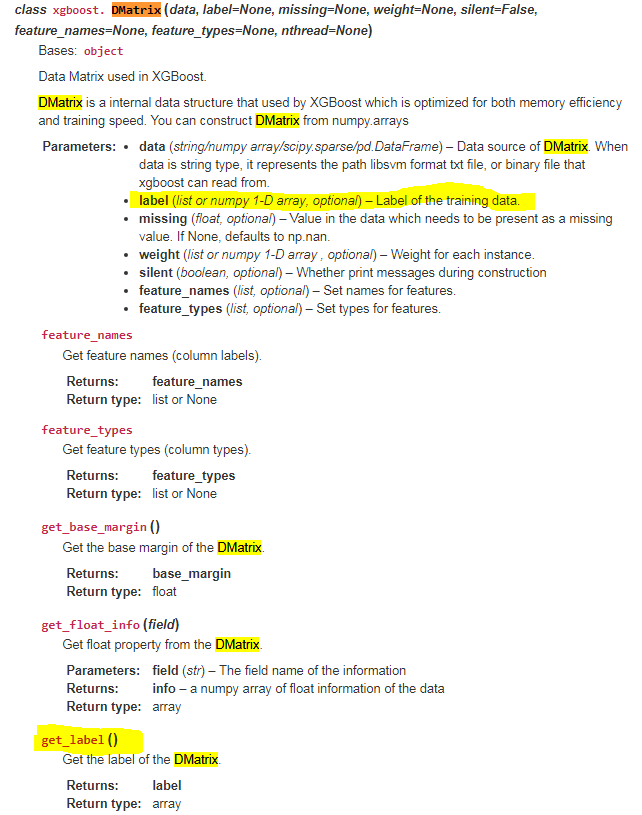

In [13]:
#模型选择，xgboost
from sklearn import model_selection
import xgboost as xgb
#test_size在0.0~1.0之间，表示验证集占比，默认0.25
X_train, X_test = model_selection.train_test_split(train,test_size=0.01)
#DMatrix:Date Matrix，是XGBoost中使用的一个内部数据结构，
#在内存效率及训练速度方面都是最优化的
#xgboost.DMatrix(data, label=None, missing=None, weight=None, silent=False, feature_names=None, feature_types=None, nthread=None)
#label转换为对数（+1，为保持标签稳定）
dtrain = xgb.DMatrix(X_train[features],np.log(X_train.Sales + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test.Sales + 1))
dtest = xgb.DMatrix(test[features])

In [18]:
#指标刻画
# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat/y-1)**2))
# def rmspe_xg(yhat, y):
#     #对数组中的每个元素计算 exp(x) - 1，对于数值很小的x,计算精度比exp(x) - 1高
#     #Get the label of the DMatrix.返回label,类型为array
#     y = np.expm1(y.get_label())
#     yhat = np.expm1(yhat)
#     return 'rmspe',rmspe(y,yhat)

#RMSPE公式中有除式，注意要去除0值，将1/yi转换为权重w,直接写成(yhat/y-1)**2)会报错
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

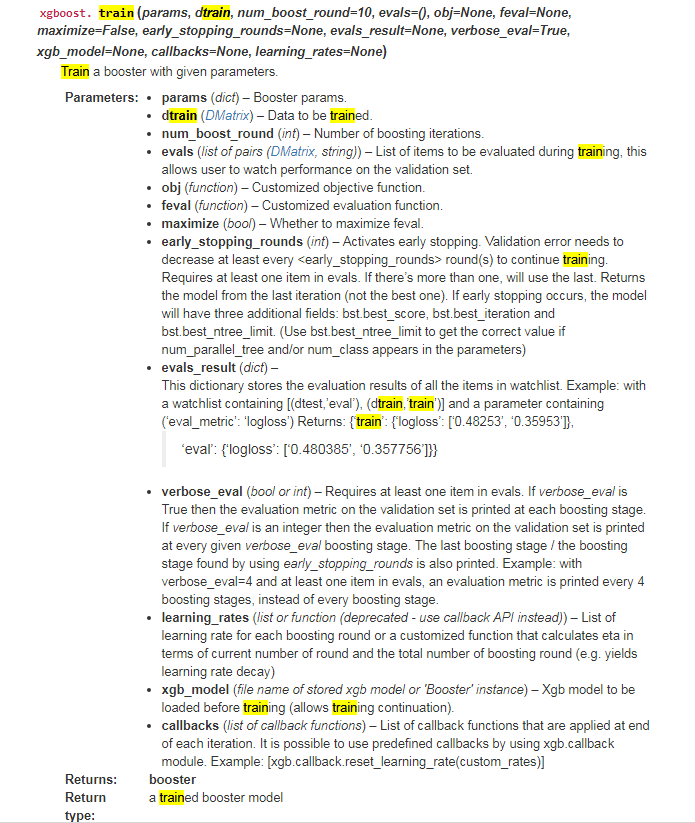

In [15]:
#Python XGBoost API
#http://xgboost.readthedocs.io/en/latest/python/python_api.html
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
            }
num_trees = 300 #boosting迭代次数
watchlist = [(dvalid, 'eval'),(dtrain, 'train')]

print("Train a XGBoost Model")
gbm = xgb.train(params, dtrain, num_trees, 
                evals=watchlist, feval= rmspe_xg,
                verbose_eval= True,
               early_stopping_rounds=50)
#不添加early_stopping_rounds=50项，默认迭代300次

Train a XGBoost Model
[0]	eval-rmse:5.78574	train-rmse:5.79399	eval-rmspe:0.996807	train-rmspe:0.996801
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.05666	train-rmse:4.06417	eval-rmspe:0.981295	train-rmspe:0.981414
[2]	eval-rmse:2.84915	train-rmse:2.85531	eval-rmspe:0.937434	train-rmspe:0.93782
[3]	eval-rmse:2.00676	train-rmse:2.01219	eval-rmspe:0.855473	train-rmspe:0.856397
[4]	eval-rmse:1.42211	train-rmse:1.42708	eval-rmspe:0.74186	train-rmspe:0.743722
[5]	eval-rmse:1.01778	train-rmse:1.02305	eval-rmspe:0.615974	train-rmspe:0.619475
[6]	eval-rmse:0.742091	train-rmse:0.747446	eval-rmspe:0.498904	train-rmspe:0.504166
[7]	eval-rmse:0.559541	train-rmse:0.565575	eval-rmspe:0.405818	train-rmspe:0.413794
[8]	eval-rmse:0.441942	train-rmse:0.447948	eval-rmspe:0.342874	train-rmspe:0.353861
[9]	eval-rmse:0.369387	train-rmse:0.375506	eval-rmspe:0.307182	train-rmspe:0.320929
[10]	

[96]	eval-rmse:0.165482	train-rmse:0.176417	eval-rmspe:0.183727	train-rmspe:0.219232
[97]	eval-rmse:0.165234	train-rmse:0.176147	eval-rmspe:0.183479	train-rmspe:0.218968
[98]	eval-rmse:0.164946	train-rmse:0.175923	eval-rmspe:0.183136	train-rmspe:0.219205
[99]	eval-rmse:0.16473	train-rmse:0.175693	eval-rmspe:0.182904	train-rmspe:0.218967
[100]	eval-rmse:0.164669	train-rmse:0.175603	eval-rmspe:0.182816	train-rmspe:0.218799
[101]	eval-rmse:0.164474	train-rmse:0.175354	eval-rmspe:0.182614	train-rmspe:0.218474
[102]	eval-rmse:0.164502	train-rmse:0.175297	eval-rmspe:0.182604	train-rmspe:0.217831
[103]	eval-rmse:0.164285	train-rmse:0.175039	eval-rmspe:0.182398	train-rmspe:0.217346
[104]	eval-rmse:0.164154	train-rmse:0.174936	eval-rmspe:0.182261	train-rmspe:0.217275
[105]	eval-rmse:0.164086	train-rmse:0.174854	eval-rmspe:0.182267	train-rmspe:0.217211
[106]	eval-rmse:0.163828	train-rmse:0.174588	eval-rmspe:0.182083	train-rmspe:0.217011
[107]	eval-rmse:0.163748	train-rmse:0.174435	eval-rmspe:0.1

[192]	eval-rmse:0.15846	train-rmse:0.168722	eval-rmspe:0.176609	train-rmspe:0.210679
[193]	eval-rmse:0.158409	train-rmse:0.16865	eval-rmspe:0.17663	train-rmspe:0.210699
[194]	eval-rmse:0.158433	train-rmse:0.168639	eval-rmspe:0.176641	train-rmspe:0.210694
[195]	eval-rmse:0.158405	train-rmse:0.168575	eval-rmspe:0.176706	train-rmspe:0.210455
[196]	eval-rmse:0.158387	train-rmse:0.168543	eval-rmspe:0.176684	train-rmspe:0.210374
[197]	eval-rmse:0.158402	train-rmse:0.168536	eval-rmspe:0.176728	train-rmspe:0.210112
[198]	eval-rmse:0.158433	train-rmse:0.16849	eval-rmspe:0.17674	train-rmspe:0.210981
[199]	eval-rmse:0.158413	train-rmse:0.168459	eval-rmspe:0.176702	train-rmspe:0.210777
[200]	eval-rmse:0.158389	train-rmse:0.168426	eval-rmspe:0.176706	train-rmspe:0.210785
[201]	eval-rmse:0.158353	train-rmse:0.168409	eval-rmspe:0.176675	train-rmspe:0.210686
[202]	eval-rmse:0.158263	train-rmse:0.168332	eval-rmspe:0.17661	train-rmspe:0.21063
[203]	eval-rmse:0.158244	train-rmse:0.168294	eval-rmspe:0.176

[288]	eval-rmse:0.157459	train-rmse:0.166791	eval-rmspe:0.175466	train-rmspe:0.208779
[289]	eval-rmse:0.157442	train-rmse:0.166769	eval-rmspe:0.175463	train-rmspe:0.208751
[290]	eval-rmse:0.157443	train-rmse:0.166764	eval-rmspe:0.175522	train-rmspe:0.209304
[291]	eval-rmse:0.157399	train-rmse:0.166742	eval-rmspe:0.175584	train-rmspe:0.209234
[292]	eval-rmse:0.1574	train-rmse:0.166731	eval-rmspe:0.175691	train-rmspe:0.20921
[293]	eval-rmse:0.1574	train-rmse:0.166726	eval-rmspe:0.175692	train-rmspe:0.209115
[294]	eval-rmse:0.157387	train-rmse:0.166715	eval-rmspe:0.175702	train-rmspe:0.209145
[295]	eval-rmse:0.157377	train-rmse:0.16671	eval-rmspe:0.17569	train-rmspe:0.209125
[296]	eval-rmse:0.157385	train-rmse:0.166709	eval-rmspe:0.175706	train-rmspe:0.209114
[297]	eval-rmse:0.157376	train-rmse:0.1667	eval-rmspe:0.175713	train-rmspe:0.209097
[298]	eval-rmse:0.157395	train-rmse:0.166696	eval-rmspe:0.175774	train-rmspe:0.209097
[299]	eval-rmse:0.157367	train-rmse:0.166689	eval-rmspe:0.17571

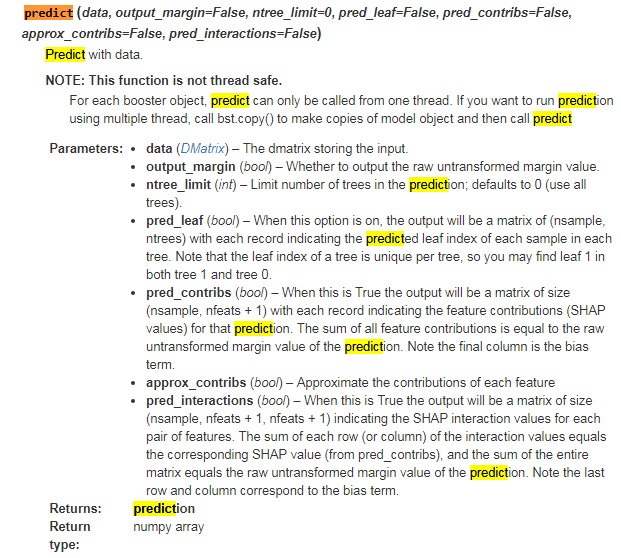

In [19]:
print('Validating')
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
#保证预测的销量非负
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs)-1, X_test['Sales'].values)
print('error', error)

Validating
error 0.17571628650706492


In [ ]:
print('Make predictions on the test set')
test_probs = gbm.predict(xgb.DMatrix(test[features]))
#保证预测的销量非负
indices = test_probs < 0
test_probs[indices] = 0
submissions = pd.DataFrame({'Id':test.Id, 'Sales':np.exp(test_probs)-1})
submissions.to_csv("xgboost_kscript_submission.csv", index=False)

In [2]:
import arch